# **Bangkit Final Project: World Coin Classification**

# **Dependencies**

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import zipfile

from tensorflow.keras import backend
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import Regularizer, l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from google.colab import files, drive

In [2]:
# Upload the kaggle.json file from Kaggle account settings page
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
# Install the Kaggle API client
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup
!chmod 600 ~/.kaggle/kaggle.json

# **Importing Dataset**

In [5]:
# Download the dataset
!kaggle datasets download -d wanderdust/coin-images

 98% 451M/459M [00:04<00:00, 107MB/s]
100% 459M/459M [00:04<00:00, 102MB/s]


In [0]:
# If kaggle is down, mount from drive
try:
    coin_file = open('/content/coin-images.zip', 'r')
    filepath = '/content/coin-images.zip'
except FileNotFoundError:
    # Keep preset values
    drive.mount('/content/drive')
    filepath = '/content/drive/My Drive/Bangkit project/Dataset/coin-images.zip'

# Unzip the dataset into folder
zip_ref = zipfile.ZipFile(filepath, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

# **Data Preparation**

In [0]:
# Define directories
data_dir = "/content/coins/data/"

train_dir = data_dir + "train/"
validation_dir = data_dir + "validation/"
test_dir = data_dir + "test/"

In [0]:
# Create generators
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=360,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      brightness_range=[0.8,1.2],
      horizontal_flip=False,
      vertical_flip=False,
      featurewise_std_normalization=False,
      featurewise_center=False,
      samplewise_std_normalization=False,
      samplewise_center=False,
      fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=360,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      brightness_range=[0.8,1.2],
      horizontal_flip=False,
      vertical_flip=False,
      featurewise_std_normalization=False,
      featurewise_center=False,
      samplewise_std_normalization=False,
      samplewise_center=False,
      fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
      rescale=1./255,
      featurewise_std_normalization=False,
      featurewise_center=False,
      samplewise_std_normalization=False,
      samplewise_center=False
)

In [9]:
# Read images from generators
batch_size = 32
image_width = 224
image_height = 224

train_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=(image_width, image_height),
      class_mode="categorical",
      batch_size=batch_size
)

validation_generator = validation_datagen.flow_from_directory(
      validation_dir,
      target_size=(image_width, image_height),
      class_mode="categorical",
      batch_size=batch_size
)

test_generator = test_datagen.flow_from_directory(
      test_dir,
      target_size=(image_width, image_height),
      class_mode="categorical",
      batch_size=1
)

Found 6413 images belonging to 211 classes.
Found 844 images belonging to 211 classes.
Found 844 images belonging to 211 classes.


# **Model**

In [10]:
# Load base model
base_model = MobileNetV2(input_shape=(image_width, image_height, 3), weights='imagenet', include_top=False)

for layer in base_model.layers:
    layer.trainable = True

    # Add regularizer
    l2_layer = l2(0.01)
    if hasattr(layer, 'kernel'):
        base_model.add_loss(lambda layer=layer: l2_layer(layer.kernel))

for layer in base_model.layers[:10]:
		layer.trainable = False

# Custom top classifier for model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.55)(x)
predictions = Dense(211, activation='softmax')(x)
model = Model(inputs=base_model.inputs, outputs=predictions)

model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________

In [11]:
# Callback to reduce learning rate if no improvement in validation loss for certain number of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-8, verbose=1)

# Callback to stop training if no improvement in validation loss for certain number of epochs
early_stop = EarlyStopping(monitor='val_loss', patience=20)

# Callback to save best model weights per epoch
weights_filepath = "best_model_weights.hdf5"
checkpoint = ModelCheckpoint(
    filepath=weights_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

model.compile(loss='categorical_crossentropy', optimizer=Nadam(lr=0.0001), metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=120,
    steps_per_epoch=50,
    validation_data=validation_generator,
    verbose=1,
    validation_steps=3,
    callbacks=[reduce_lr, checkpoint]
)

Epoch 1/120
50/50 [==============================] - ETA: 0s - loss: 5.5496 - accuracy: 0.0081
Epoch 00001: val_accuracy improved from -inf to 0.00000, saving model to best_model_weights.hdf5
50/50 [==============================] - 30s 602ms/step - loss: 5.5496 - accuracy: 0.0081 - val_loss: 5.5265 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/120
50/50 [==============================] - ETA: 0s - loss: 5.2693 - accuracy: 0.0156
Epoch 00002: val_accuracy did not improve from 0.00000
50/50 [==============================] - 29s 581ms/step - loss: 5.2693 - accuracy: 0.0156 - val_loss: 5.5111 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/120
50/50 [==============================] - ETA: 0s - loss: 5.1864 - accuracy: 0.0431
Epoch 00003: val_accuracy improved from 0.00000 to 0.02083, saving model to best_model_weights.hdf5
50/50 [==============================] - 29s 590ms/step - loss: 5.1864 - accuracy: 0.0431 - val_loss: 5.3121 - val_accuracy: 0.0208 - lr: 1.0000e-04
Epoch 4/

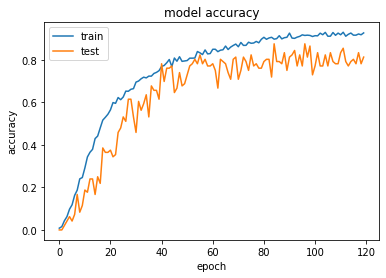

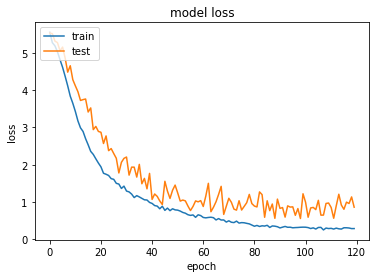

In [12]:
# Visualise accuracy history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Visualise loss history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Save model
model.save("mobilenet_model.h5")

In [14]:
# Evaluate model
train_score = model.evaluate(train_generator, verbose=1)
print("Training loss: ", train_score[0])
print("Training accuracy: ", train_score[1])

validation_score = model.evaluate(validation_generator, verbose=1)
print("Validation loss: ", validation_score[0])
print("Validation accuracy: ", validation_score[1])

test_score = model.evaluate(test_generator, verbose=1)
print("Testing loss: ", test_score[0])
print("Testing accuracy: ", test_score[1])

201/201 [==============================] - 102s 508ms/step - loss: 0.0982 - accuracy: 0.9715
Training loss:  0.09816599637269974
Training accuracy:  0.971464216709137
27/27 [==============================] - 13s 485ms/step - loss: 0.8529 - accuracy: 0.8045
Validation loss:  0.8528911471366882
Validation accuracy:  0.8045023679733276
844/844 [==============================] - 6s 8ms/step - loss: 0.6531 - accuracy: 0.8365
Testing loss:  0.6530923843383789
Testing accuracy:  0.8364928960800171


In [0]:
model_best_weights = model

# Load best model weights
model_best_weights.load_weights(weights_filepath)

# Save model
model_best_weights.save("mobilenet_model_best_weights.h5")

In [16]:
# Evaluate model
train_score = model_best_weights.evaluate(train_generator, verbose=1)
print("Training loss: ", train_score[0])
print("Training accuracy: ", train_score[1])

validation_score = model_best_weights.evaluate(validation_generator, verbose=1)
print("Validation loss: ", validation_score[0])
print("Validation accuracy: ", validation_score[1])

test_score = model_best_weights.evaluate(test_generator, verbose=1)
print("Testing loss: ", test_score[0])
print("Testing accuracy: ", test_score[1])

201/201 [==============================] - 102s 507ms/step - loss: 0.1457 - accuracy: 0.9607
Training loss:  0.1456790268421173
Training accuracy:  0.9607048034667969
27/27 [==============================] - 13s 475ms/step - loss: 0.8649 - accuracy: 0.7974
Validation loss:  0.8649319410324097
Validation accuracy:  0.7973933815956116
844/844 [==============================] - 6s 8ms/step - loss: 0.6799 - accuracy: 0.8246
Testing loss:  0.6798509955406189
Testing accuracy:  0.8246445655822754


In [0]:
# Predict test images
predictions = []

for filename in test_generator.filenames:
    img = load_img(test_dir+filename, target_size=(image_width, image_height))
    img = img_to_array(img)/255
    img_expand = np.expand_dims(img, axis=0)
    predictions.append(model.predict(img_expand)[0])

In [0]:
# Get index of largest probability
predicted_indices = np.argmax(predictions, axis=1)

# Get coin directory name from index 
directories = dict((v, k) for k, v in train_generator.class_indices.items())
predicted_dir = [directories.get(k) for k in predicted_indices]

# Get label name from coin directory name
with open(data_dir + 'cat_to_name.json', 'r') as json_file:
    labels = json.load(json_file)
predicted_labels = [labels.get(str(k)) for k in predicted_dir]

In [19]:
# Save predicted labels as CSV file
filenames = test_generator.filenames
results = pd.DataFrame({"Filename": filenames, "Predictions": predicted_labels})
results.to_csv("mobilenet_results.csv", index=False)
results.head()

,Filename,Predictions
0,1/021__1 Cent_australia.jpg,"1 Cent,Australian dollar,australia"
1,1/022__1 Cent_australia.jpg,"1 Cent,Australian dollar,australia"
2,1/027__1 Cent_australia.jpg,"1 Cent,Australian dollar,australia"
3,1/036__1 Cent_australia.jpg,"1 Cent,Australian dollar,australia"
4,10/005__5 Centavos_brazil.jpg,"5 Centavos,Brazilian Real,brazil"


# **Convert to TFLite**

In [20]:
# Create converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS]
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_model = converter.convert()
open("mobilenet_model.tflite", "wb").write(tflite_model)

3054968

# **Copy model to Drive**

In [21]:
drive.mount('/content/drive')
!cp mobilenet_model.h5 "/content/drive/My Drive/Bangkit project/models"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
